# Load in Data

In [1]:
import warnings
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf

keras = tf.keras
from pmdarima.arima import auto_arima

!pip install pmdarima

### Update Data


In [2]:
# Read data in to dataframes
spy = pd.read_csv('../SPY.csv')

spy['Date'] = pd.to_datetime(spy['Date'])


FileNotFoundError: [Errno 2] No such file or directory: '../SPY.csv'

### SPY Train Test Split

Here we can see our complete plot in terms of time steps. Our entire data set is just shy of 7000 time steps. We know that our data is in days, so our data is just shy of 7000 daily observations. We need to separate out a training and validation set to see how our model holds up.

I will be choosing an arbitrary date to separate the training, validation, and test data.

In [10]:
series = spy['Close']

# Create train data set
train_split_date = '2014-12-31'
train_split_index = np.where(spy.Date == train_split_date)[0][0]
x_train = spy.loc[spy['Date'] <= train_split_date]['Close']

# Create test data set
test_split_date = '2019-01-02'
test_split_index = np.where(spy.Date == test_split_date)[0][0]
x_test = spy.loc[spy['Date'] >= test_split_date]['Close']

# Create valid data set
valid_split_index = (train_split_index.max(),test_split_index.min())
x_valid = spy.loc[(spy['Date'] < test_split_date) & (spy['Date'] > train_split_date)]['Close']

NameError: name 'spy' is not defined

5521 5522 6527 6528 6949


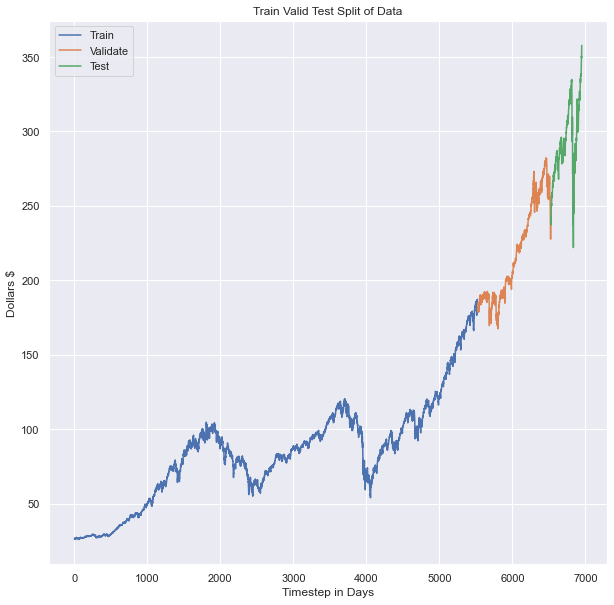

In [5]:
# set style of charts
sns.set(style="darkgrid")
plt.rcParams['figure.figsize'] = [10, 10]

# Create a plot showing the split of the train, valid, and test data
plt.plot(x_train, label = 'Train')
plt.plot(x_valid, label = 'Validate')
plt.plot(x_test, label = 'Test')
plt.title('Train Valid Test Split of Data')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.legend()
print(x_train.index.max(),x_valid.index.min(),x_valid.index.max(),x_test.index.min(),x_test.index.max())

In [8]:
# Lets create a dictionary to store all of our model training scores to view later
model_mae_scores = {}

# Base Model - Naive Forecasting
A naive forecast is naive because it takes the price from the day before and uses that price for the prediction of tomorrow. This is suprisingly effecting in this scenario due to the relatively due to autocorrelation. The price of tomorrow is dependent on the price today. Tomorrow's market open price is very close to the price of today's close.

In [9]:
# Plot chart with all details untouched
plot_series(time=spy.index,series=spy['Close'], label = 'Spy Close Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Price History of SPY Jan-1993 to Sept-2020')

NameError: name 'plot_series' is not defined

In [8]:
naive_forecast = series[test_split_index-1 :-1]

Text(0.5, 1.0, 'Naive Forecast vs Actual')

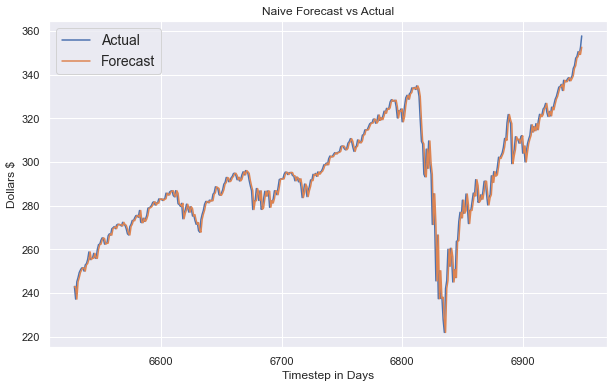

In [9]:
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Actual")
plot_series(x_test.index, naive_forecast, label="Forecast")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('Naive Forecast vs Actual')

### Calculate Error in Naive Model

In [10]:
# Alternative way to show MAE to stay consistent with what we will be doing later
naive_forecast_mae = keras.metrics.mean_absolute_error(x_test, naive_forecast).numpy()
model_mae_scores['naive'] = naive_forecast_mae

# view the dictionary of mae scores
model_mae_scores

{'naive': 2.722772511848341}

In [11]:
# Show first 3 values of our forecast
print(naive_forecast.values[:3])

# Show first 3 values of validation data
print(x_test.values[:3])

# Calculate and show first 3 values of the calculated error (MAE)
print('*'*100)
print(np.abs(naive_forecast[:3].values - x_test[:3].values))

[242.77 243.03 237.23]
[243.03 237.23 245.17]
****************************************************************************************************
[0.26 5.8  7.94]


# Monthly Moving Average Model (20 Day MA)
Moving Averages are not true prediction models, however it is an important topic to demonstrate. When you hear someone talk about how they want to "de-trend" or "smooth" data they are usually talking about implementing some sort of moving average. There are multiple moving average types with the most common being simple and exponential. Simple is just the average price over the desired time span. Exponential is a little more complicated as it provides a weight factor to each time step in the window. The weights are applied to make the more recent time steps more important that the later time steps. This allows the moving average to respond much more quickly to abrupt changes.

Text(0.5, 1.0, 'SMA20 vs Actual')

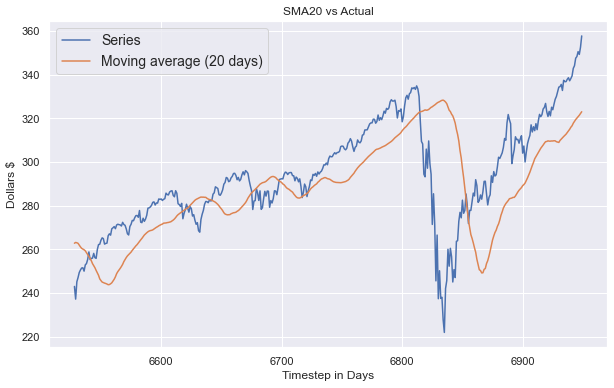

In [12]:
# Choose a window size for the moving average
window = 20

# Create a moving average over the entire dataset
moving_avg = spy['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:spy.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (20 days)")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('SMA20 vs Actual')

In [13]:
ma_20 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

model_mae_scores['SMA 20'] = ma_20
model_mae_scores

{'naive': 2.722772511848341, 'SMA 20': 16.962856635071088}

# Weekly Moving Average (5 day MA)
I have modeled a 20 day moving average and a 5 day moving average. This is because there are only 5 trading days a week which means 20 trading in a month. So these two moving averages show the weekly trend and the monthly trends of the S&P500. These moving averages are typically used to generate trading signals. For example, if the 5 SMA overtakes the 20 SMA that means the price is in a recent up trend and you may want to play that momentum going forward.

Text(0.5, 1.0, 'SMA5 Forecast vs Actual')

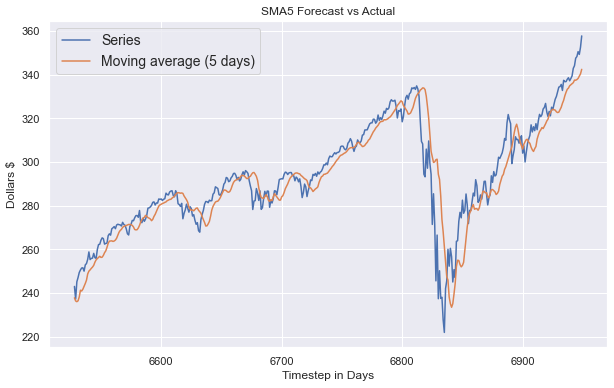

In [14]:
# Choose a window size for the moving average
window = 5

# Create a moving average over the entire dataset
moving_avg = spy['Close'].rolling(window=window).mean()

# Slice the moving average on the forecast
moving_avg_forecast = moving_avg.values[test_split_index - window:spy.index.max() - window + 1]
                                         
plt.figure(figsize=(10, 6))
plot_series(x_test.index, x_test, label="Series")
plot_series(x_test.index, moving_avg_forecast, label="Moving average (5 days)")
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('SMA5 Forecast vs Actual')

In [15]:
# Calculate MAE
ma_5 = keras.metrics.mean_absolute_error(x_test, moving_avg_forecast).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['SMA 5'] = ma_5
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071088,
 'SMA 5': 6.754151658767775}

# ARIMA

### Step 1: Is the data stationary?

Use Augmented Dickey Fuller test to determine if the data is stationary
- Failure to reject the null hypothesis means the data is not stationary

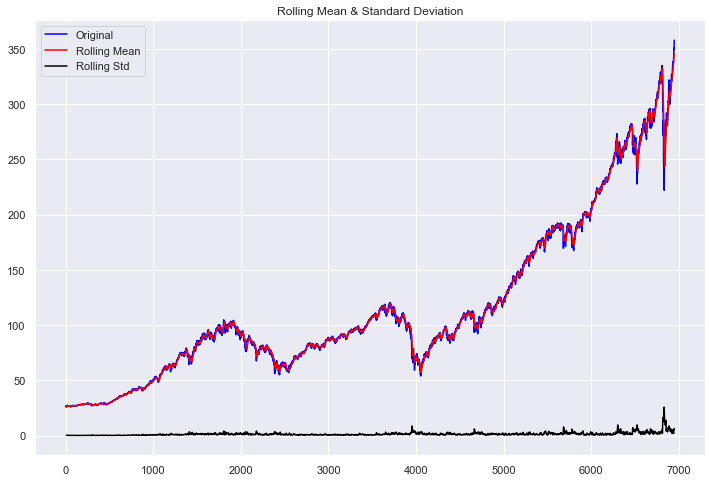

Results of Dickey-Fuller Test:
p-value = 0.9985. The series is likely non-stationary.
Test Statistic                    1.881042
p-value                           0.998497
#Lags Used                       20.000000
Number of Observations Used    6929.000000
Critical Value (1%)              -3.431294
Critical Value (5%)              -2.861957
Critical Value (10%)             -2.566992
dtype: float64


In [16]:
test_stationarity(series)

The **p-value is obtained is greater than significance level of 0.05** and the **ADF statistic is higher than any of the critical values.**

Clearly, there is no reason to reject the null hypothesis. **So, the time series is in fact non-stationary.** Since our data is not statio

### Step 2 Differencing
We must convert our non-stationary data to stationary data using the differencing method. This means we take the value at time (t) and subtract the value at time (t-1) to get the difference. This difference is also the calculated return over that period. Since our time steps are in days this differencing is the daily return.

In [17]:
# Get the difference of each Adj Close point
spy_close_diff_1 = series.diff()
spy_close_diff_1.dropna(inplace=True)

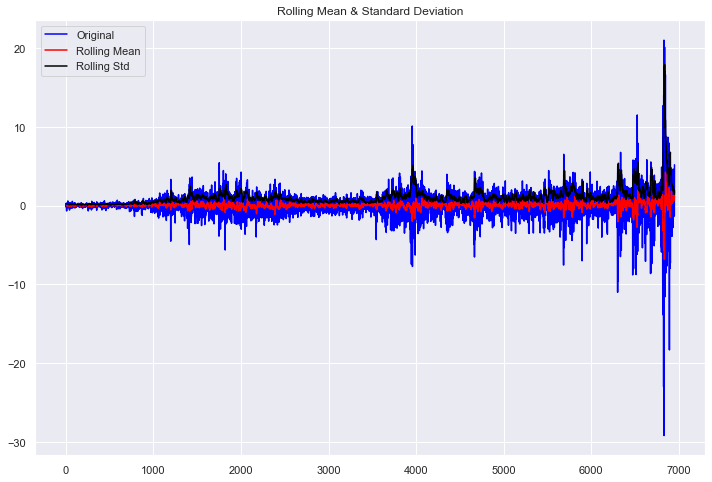

Results of Dickey-Fuller Test:
p-value = 0.0000. The series is likely stationary.
Test Statistic                -1.831861e+01
p-value                        2.268280e-30
#Lags Used                     1.900000e+01
Number of Observations Used    6.929000e+03
Critical Value (1%)           -3.431294e+00
Critical Value (5%)           -2.861957e+00
Critical Value (10%)          -2.566992e+00
dtype: float64


In [18]:
# Plot the spy Adj Close 1st order difference
test_stationarity(spy_close_diff_1)

The **p-value is obtained is less than significance level of 0.05** and the **ADF statistic is lower than any of the critical values.**

We reject the null hypothesis. **So, the time series is in fact stationary.** 

Auto ARIMA: Automatically discover the optimal order for an ARIMA model.
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

The auro_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

In [6]:
model_autoARIMA = auto_arima(x_train, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

NameError: name 'x_train' is not defined

### Step 4: Building the Arima Model and Forecasting
Now that we have experimented and found our prefered model order of (1,1,1) lets build the model and get some forecasts.

This cell takes a while to run. Be careful. We have stored the model predictions using a magic method so we do not have to re-run this time consuming cell everytime.

In [28]:
# Create list of x train valuess
history = [x for x in x_train]

# establish list for predictions
model_predictions = []

# Count number of test data points
N_test_observations = len(x_test)

# loop through every data point
for time_point in list(x_test.index):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = x_test[time_point]
    history.append(true_test_value)
MAE_error = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()
print('Testing Mean Squared Error is {}'.format(MAE_error))

%store model_predictions

Testing Mean Squared Error is 2.8056150202922994
Stored 'model_predictions' (list)


In [29]:
# %store model_predictions
%store -r model_predictions

# Check to see if it reloaded
model_predictions[:5]

[184.4708883366989,
 238.1585961149958,
 234.9745903710062,
 244.2264620723263,
 247.03115485181263]

In [30]:
#save model
model_fit.save('arima_111.pkl')

# Load model
from statsmodels.tsa.arima.model import ARIMAResults
loaded = ARIMAResults.load('arima_111.pkl')

In [31]:
model_predictions = np.array(model_predictions).flatten()

# Calculate MAE
arima_mae = keras.metrics.mean_absolute_error(x_test, model_predictions).numpy()

# Save to our dictionary of model mae scores
model_mae_scores['ARIMA'] = arima_mae
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071088,
 'SMA 5': 6.754151658767775,
 'ARIMA': 2.8056150202922994}

- You may want to zoom in on the plot below to get a better view of the differences. To do this simply use the [:] slicing on x_test.index and model_predictions/x_test in the plt.plot() lines. I typically like to do [-100:] to get the last 100 values

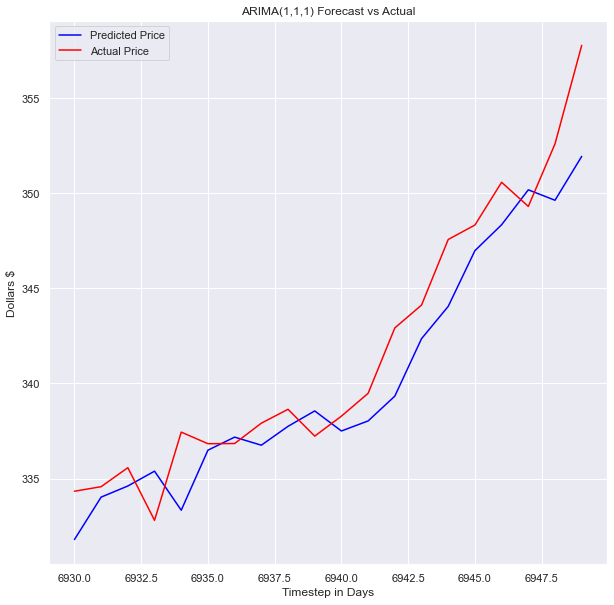

<Figure size 720x432 with 0 Axes>

In [32]:
# Plot our predictions against the actual values for a visual comparison.
plt.plot(x_test.index[-20:], model_predictions[-20:], color='blue',label='Predicted Price')
plt.plot(x_test.index[-20:], x_test[-20:], color='red', label='Actual Price')
plt.ylabel('Dollars $')
plt.xlabel('Timestep in Days')
plt.title('ARIMA(1,1,1) Forecast vs Actual')
# plt.xticks(np.arange(881,1259,50), df.Date[881:1259:50])
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

#### Show Error in model vs actual

In [33]:
# Find the Error in the ARIMA Model
arima_error = model_predictions - x_test

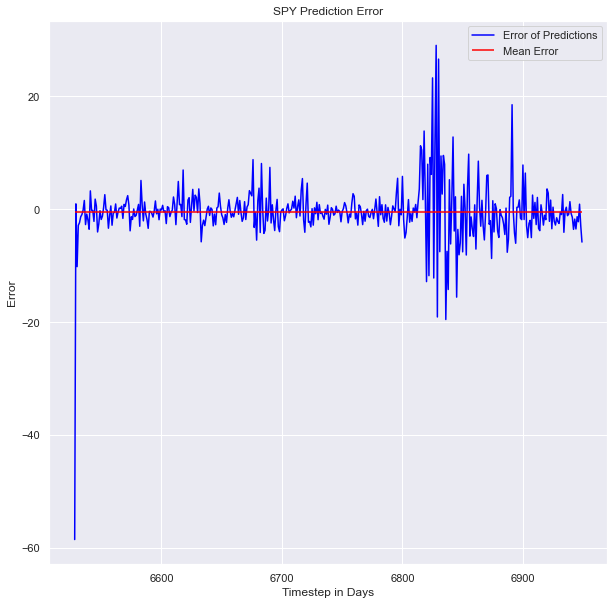

<Figure size 720x432 with 0 Axes>

In [34]:
plt.plot(x_test.index, arima_error, color='blue',label='Error of Predictions')
plt.hlines(np.mean(arima_error),xmin=x_test.index.min(),xmax=x_test.index.max(), color = 'red', label = 'Mean Error')
# plt.plot(x_valid.index, x_valid, color='red', label='Actual Price')
plt.title('SPY Prediction Error')
plt.xlabel('Timestep in Days')
plt.ylabel('Error')
plt.legend()
plt.figure(figsize=(10,6))
plt.show()

# Summary of ALL Model Results

In [35]:
# Store MAE scores
%store model_mae_scores

Stored 'model_mae_scores' (dict)


In [36]:
%store -r model_mae_scores
mae_series = pd.Series(model_mae_scores)
model_mae_scores

{'naive': 2.722772511848341,
 'SMA 20': 16.962856635071088,
 'SMA 5': 6.754151658767775,
 'ARIMA': 2.8056150202922994}

In [37]:
# Sort vales for clean bar chart
order = mae_series.sort_values()

Text(0.5, 1.0, 'Mean Average Error of All Models Tested')

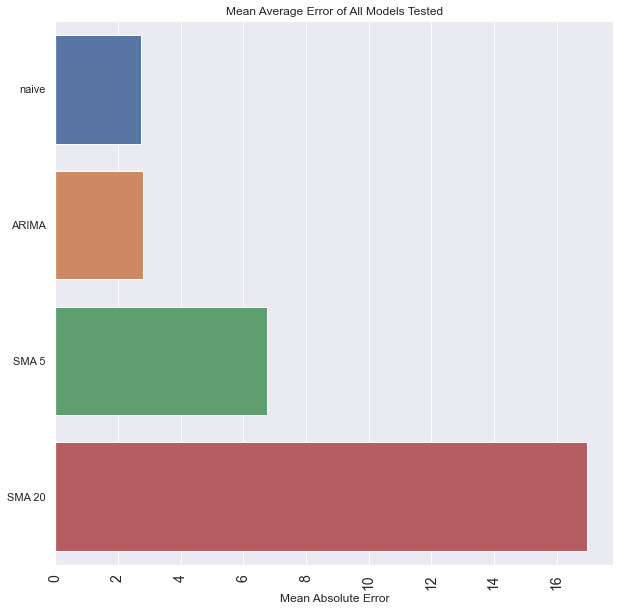

In [38]:
# Create bar chart for to show MAE of all models side by side
sns.barplot(x=order.values, y = order.index, orient='h')
plt.xlabel('Mean Absolute Error')
plt.xticks(rotation='vertical',fontsize=14)
plt.title('Mean Average Error of All Models Tested')
